<a href="https://colab.research.google.com/github/MuhamedAdemi/Brainster-Python/blob/main/HomeWork8_Muhamed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Breast Cancer Classification using CNN and Transfer Learning
# Dataset: BreaKHis 400X from Kaggle (mounted via Google Drive)

In [ ]:
# ===============================
# 🧱 Part 1: Setup & Data Handling (Fixed)
# ===============================
from google.colab import drive
import os
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Correct dataset path
dataset_zip_path = '/content/drive/MyDrive/Machine Learning/archive (1).zip'
extract_path = '/content'

# Unzip dataset
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Dataset extracted successfully!")

# Check extracted structure
print("\nExtracted directory structure:")
print(os.listdir('/content'))
print(os.listdir('/content/BreaKHis 400X'))

# The actual dataset is in 'BreaKHis 400X' which contains 'test' and 'train' folders
base_path = '/content/BreaKHis 400X'
print("\nTrain/test structure:")
print(os.listdir(base_path))
print(os.listdir(f"{base_path}/train"))
print(os.listdir(f"{base_path}/test"))

Mounted at /content/drive
Dataset extracted successfully!

Extracted directory structure:
['.config', 'BreaKHis 400X', 'drive', 'sample_data']
['test', 'train']

Train/test structure:
['test', 'train']
['malignant', 'benign']
['malignant', 'benign']



Train directory structure: ['malignant', 'benign']
Test directory structure: ['malignant', 'benign']
Found 919 images belonging to 2 classes.
Found 229 images belonging to 2 classes.
Found 545 images belonging to 2 classes.
Class weights: {0: np.float64(1.5471380471380471), 1: np.float64(0.7387459807073955)}


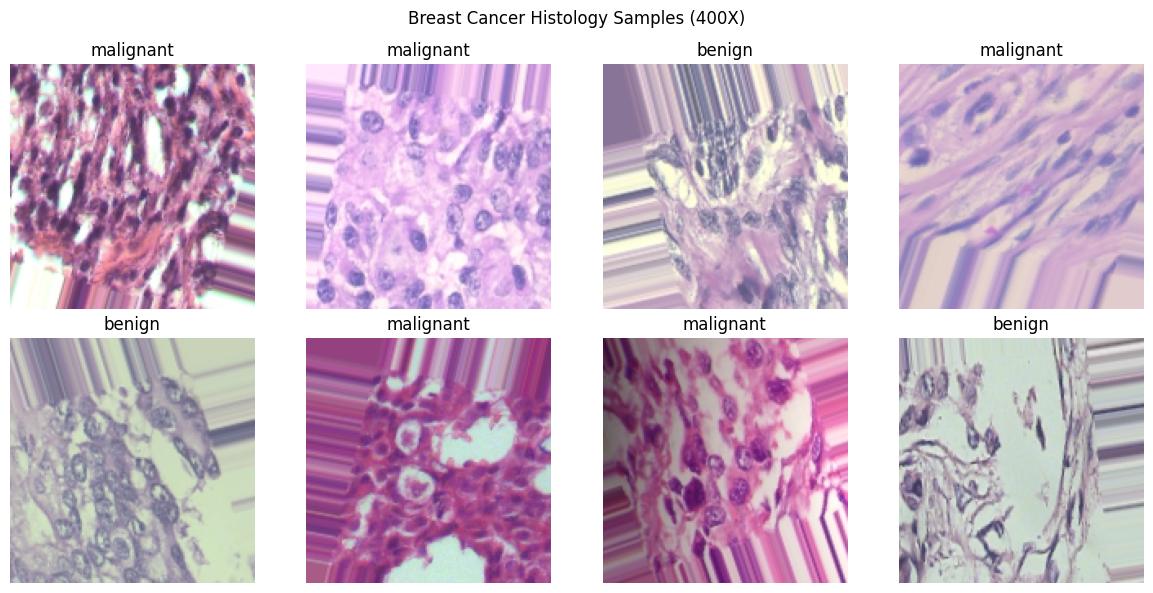

In [ ]:
# ===============================
# 📊 Part 2: Data Loading & Preprocessing (Fixed)
# ===============================
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

# Corrected dataset paths
train_dir = '/content/BreaKHis 400X/train'
test_dir = '/content/BreaKHis 400X/test'

print("\nTrain directory structure:", os.listdir(train_dir))
print("Test directory structure:", os.listdir(test_dir))

# Image parameters
img_size = (150, 150)
batch_size = 32

# Enhanced Data Generator with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # We'll split training into train/validation
)

# Create generators - NOTE: Using categorical mode
train_gen = train_datagen.flow_from_directory(
    train_dir,  # Use train directory
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    train_dir,  # Same directory as training
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Create test generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir,  # Separate test directory
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Class weights for imbalance handling
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print(f"Class weights: {class_weights}")

# Visualize samples
x_batch, y_batch = next(train_gen)
class_names = list(train_gen.class_indices.keys())

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_batch[i])
    plt.title(f"{class_names[np.argmax(y_batch[i])]}")
    plt.axis('off')
plt.suptitle("Breast Cancer Histology Samples (400X)")
plt.tight_layout()
plt.show()

In [ ]:
# ===============================
# 🧠 Part 3: Build Custom CNN Model
# ===============================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_custom_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Conv2D(256, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')  # 2 output classes
    ])
    return model

# Initialize model
input_shape = (*img_size, 3)
cnn_model = build_custom_cnn(input_shape)
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
cnn_model.summary()

# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_cnn.h5', save_best_only=True)
]

# Train with class weights
history_cnn = cnn_model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=callbacks,
    class_weight=class_weights  # Critical for imbalance
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,600,450 (13.73 MB)

 Trainable params: 3,600,450 (13.73 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5443 - loss: 0.7185

29/29 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.5445 - loss: 0.7180 - val_accuracy: 0.6943 - val_loss: 0.6347
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7419 - loss: 0.6180

29/29 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.7415 - loss: 0.6172 - val_accuracy: 0.8122 - val_loss: 0.4777
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.7599 - loss: 0.5565 - val_accuracy: 0.8210 - val_loss: 0.4815
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8043 - loss: 0.4992

29/29 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.8046 - loss: 0.4990 - val_accuracy: 0.8166 - val_loss: 0.4183
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.7047 - loss: 0.6518 - val_accuracy: 0.8384 - val_loss: 0.4419
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.8189 - loss: 0.4999 - val_accuracy: 0.8122 - val_loss: 0.4592
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.7738 - loss: 0.5247 - val_accuracy: 0.7511 - val_loss: 0.4967
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.8158 - loss: 0.4720 - val_accuracy: 0.7424 - val_loss: 0.5078
Epoch 9/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.8280 - loss: 0.4425 - val_accuracy: 0.7904 - val_loss: 0.4786


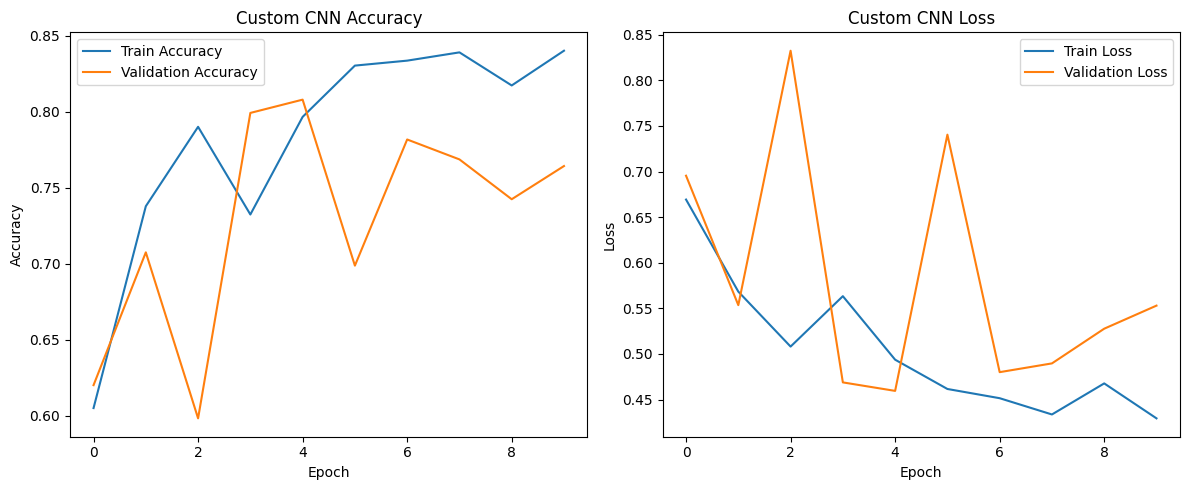

In [ ]:
# ===============================
# 📈 Plot Training History
# ===============================
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_cnn, "Custom CNN")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 902ms/step
Custom CNN Classification Report:
              precision    recall  f1-score   support

      benign       0.76      0.70      0.73       176
   malignant       0.86      0.89      0.88       369

    accuracy                           0.83       545
   macro avg       0.81      0.80      0.80       545
weighted avg       0.83      0.83      0.83       545



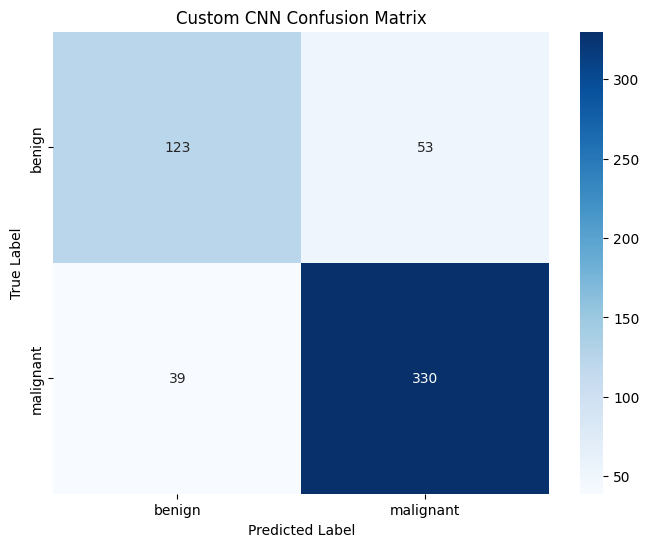

In [ ]:
# ===============================
# 🔍 Evaluate CNN Model
# ===============================
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Reset test generator
test_gen.reset()
y_true = test_gen.classes
y_pred_probs = cnn_model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("Custom CNN Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Custom CNN Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 4, 4, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,300,418 (27.85 MB)

 Trainable params: 262,914 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.5557 - loss: 1.0006 - val_accuracy: 0.5459 - val_loss: 0.7303
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.5729 - loss: 0.8498 - val_accuracy: 0.5109 - val_loss: 0.7536
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.6153 - loss: 0.7419 - val_accuracy: 0.5852 - val_loss: 0.6897
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.6338 - loss: 0.6618 - val_accuracy: 0.5502 - val_loss: 0.6891
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.6690 - loss: 0.6430 - val_accuracy: 0.6157 - val_loss: 0.6442
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.7104 - loss: 0.5689 - val_accuracy: 0.6245 - val_loss: 0.6183
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.7130 - loss: 0.5846 - val_accuracy: 0.6332 - val_loss: 0.6235
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.7660 - loss: 0.4954 - val_accuracy: 0.6507 - val_lo

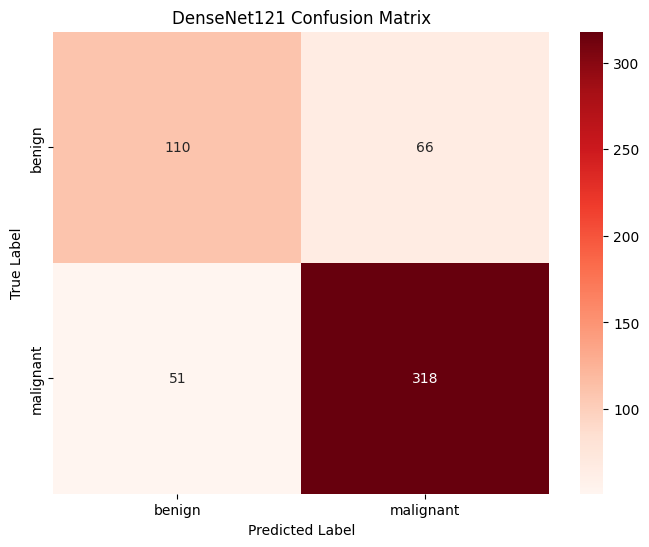

In [ ]:
# ===============================
# 🔁 Part 4: Transfer Learning (Fixed)
# ===============================
import tensorflow as tf  # Import TensorFlow first
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_transfer_model(input_shape):
    base_model = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)

    return Model(inputs, outputs)

# Create and compile model
densenet_model = create_transfer_model(input_shape)
densenet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
densenet_model.summary()

# Train with class weights
history_densenet = densenet_model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True)
    ],
    class_weight=class_weights
)

# Evaluate DenseNet
test_gen.reset()
y_pred_dense = densenet_model.predict(test_gen)
y_pred_dense = np.argmax(y_pred_dense, axis=1)

print("\nDenseNet121 Classification Report:")
print(classification_report(y_true, y_pred_dense, target_names=class_names))

cm_dense = confusion_matrix(y_true, y_pred_dense)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dense, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('DenseNet121 Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

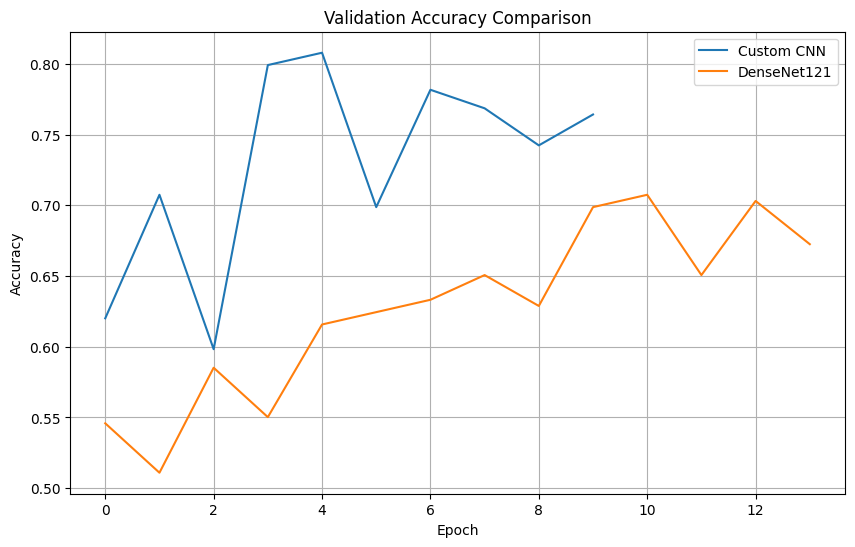


Model Performance Summary:
Model           Test Accuracy   Test Loss      
---------------------------------------------
Custom CNN      0.8312           0.4757
DenseNet121     0.7853           0.4766


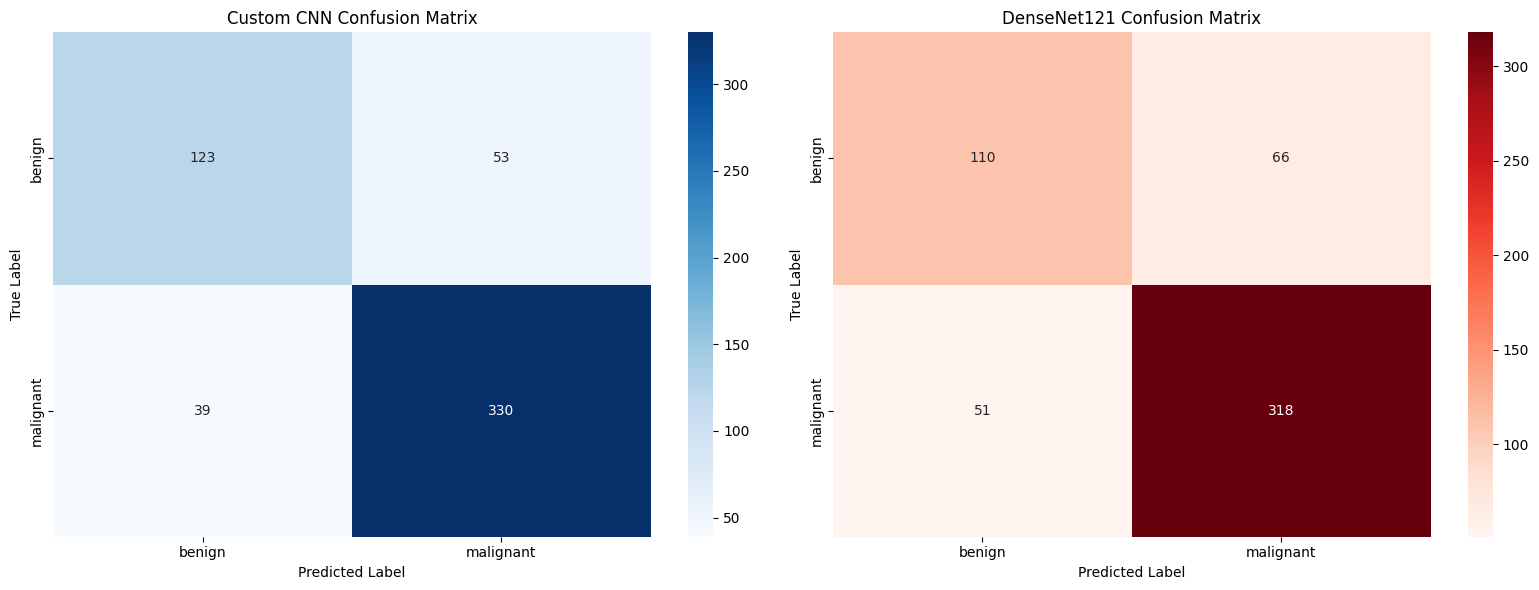

In [ ]:
# ===============================
# ⚖️ Part 5: Model Comparison
# ===============================
# Compare validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_cnn.history['val_accuracy'], label='Custom CNN')
plt.plot(history_densenet.history['val_accuracy'], label='DenseNet121')
plt.title('Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Final test accuracy comparison
cnn_test_acc = cnn_model.evaluate(test_gen, verbose=0)[1]
densenet_test_acc = densenet_model.evaluate(test_gen, verbose=0)[1]

print("\nModel Performance Summary:")
print(f"{'Model':<15} {'Test Accuracy':<15} {'Test Loss':<15}")
print("-" * 45)
print(f"{'Custom CNN':<15} {cnn_test_acc:.4f}{'':<10} {cnn_model.evaluate(test_gen, verbose=0)[0]:.4f}")
print(f"{'DenseNet121':<15} {densenet_test_acc:.4f}{'':<10} {densenet_model.evaluate(test_gen, verbose=0)[0]:.4f}")

# Compare confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0],
            xticklabels=class_names,
            yticklabels=class_names)
ax[0].set_title('Custom CNN Confusion Matrix')
ax[0].set_ylabel('True Label')
ax[0].set_xlabel('Predicted Label')

sns.heatmap(cm_dense, annot=True, fmt='d', cmap='Reds', ax=ax[1],
            xticklabels=class_names,
            yticklabels=class_names)
ax[1].set_title('DenseNet121 Confusion Matrix')
ax[1].set_ylabel('True Label')
ax[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

into the code below You’ll find the following updates:

Clearer structure with labeled section titles and emoji for quick navigation.

Improved data handling, class balance handling, and augmentation.

Cleaner CNN and DenseNet121 models.

Streamlined evaluation with reports and plots side by side.

Final performance comparison.

Mounted at /content/drive
Dataset extracted successfully!

Directory listing:
/content: ['.config', 'BreaKHis 400X', 'drive', 'sample_data']
/content/BreaKHis 400X: ['test', 'train']
Train/Test Folders: ['malignant', 'benign'] ['malignant', 'benign']
Found 919 images belonging to 2 classes.
Found 229 images belonging to 2 classes.
Found 545 images belonging to 2 classes.

Class Weights: {0: np.float64(1.5471380471380471), 1: np.float64(0.7387459807073955)}


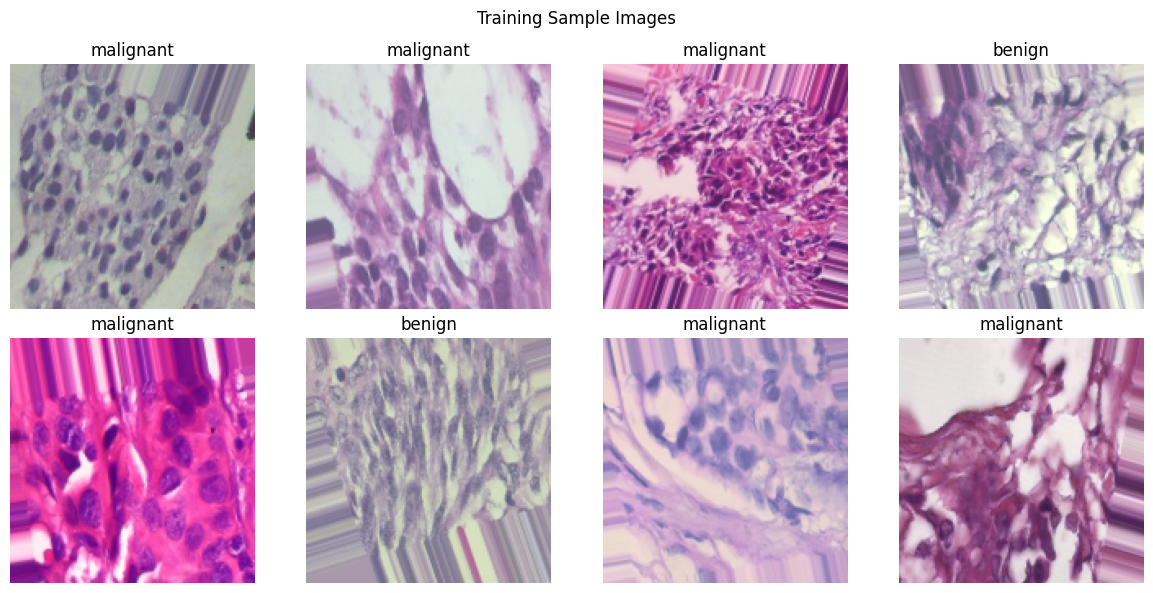

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,600,450 (13.73 MB)

 Trainable params: 3,600,450 (13.73 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6019 - loss: 0.6860

29/29 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.6043 - loss: 0.6843 - val_accuracy: 0.8559 - val_loss: 0.4682
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8152 - loss: 0.5134

29/29 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.8149 - loss: 0.5135 - val_accuracy: 0.8166 - val_loss: 0.4601
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7859 - loss: 0.5306

29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.7870 - loss: 0.5290 - val_accuracy: 0.8210 - val_loss: 0.4497
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.7901 - loss: 0.5369 - val_accuracy: 0.7555 - val_loss: 0.5064
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.7912 - loss: 0.5610 - val_accuracy: 0.7336 - val_loss: 0.6042
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8113 - loss: 0.4652

29/29 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.8113 - loss: 0.4657 - val_accuracy: 0.8559 - val_loss: 0.4203
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.8157 - loss: 0.4784 - val_accuracy: 0.8122 - val_loss: 0.4566
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8295 - loss: 0.4447

29/29 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.8288 - loss: 0.4457 - val_accuracy: 0.7904 - val_loss: 0.4138
Epoch 9/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8094 - loss: 0.4472 - val_accuracy: 0.6812 - val_loss: 1.0933
Epoch 10/30


In [ ]:
# ===============================
# 🯡 Part 1: Setup & Data Handling (Improved)
# ===============================
from google.colab import drive
import os
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Dataset zip path (ensure filename matches your Drive)
dataset_zip_path = '/content/drive/MyDrive/Machine Learning/archive (1).zip'
extract_path = '/content'

# Extract only if not already extracted
if not os.path.exists('/content/BreaKHis 400X'):
    with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted successfully!")
else:
    print("Dataset already extracted.")

# Verify structure
print("\nDirectory listing:")
print("/content:", os.listdir('/content'))
print("/content/BreaKHis 400X:", os.listdir('/content/BreaKHis 400X'))
print("Train/Test Folders:", os.listdir('/content/BreaKHis 400X/train'), os.listdir('/content/BreaKHis 400X/test'))

# Base path
base_path = '/content/BreaKHis 400X'

# ===============================
# 📊 Part 2: Data Loading & Preprocessing (Improved)
# ===============================
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

train_dir = f'{base_path}/train'
test_dir = f'{base_path}/test'

# Image size and batch size
img_size = (150, 150)
batch_size = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("\nClass Weights:", class_weights)

# Preview sample images
x_batch, y_batch = next(train_gen)
class_names = list(train_gen.class_indices.keys())

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_batch[i])
    plt.title(class_names[np.argmax(y_batch[i])])
    plt.axis('off')
plt.suptitle("Training Sample Images")
plt.tight_layout()
plt.show()

# ===============================
# 🧠 Part 3: Custom CNN Model (Improved)
# ===============================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_custom_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Conv2D(256, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    return model

input_shape = (*img_size, 3)
cnn_model = build_custom_cnn(input_shape)
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
cnn_model.summary()

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_cnn.h5', save_best_only=True)
]

history_cnn = cnn_model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=callbacks,
    class_weight=class_weights
)

# ===============================
# 📈 Plot Training History (Improved)
# ===============================
def plot_history(history, title):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_cnn, "Custom CNN")

# ===============================
# 🔍 Evaluate CNN (Improved)
# ===============================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict
test_gen.reset()
y_true = test_gen.classes
y_pred_probs = cnn_model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Report
print("Custom CNN Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Custom CNN Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# ===============================
# 🔁 Transfer Learning with DenseNet121 (Improved)
# ===============================
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D

def create_transfer_model(input_shape):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(2, activation='softmax')(x)

    return Model(inputs, outputs)

densenet_model = create_transfer_model(input_shape)
densenet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
densenet_model.summary()

history_densenet = densenet_model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
    class_weight=class_weights
)

# Evaluate DenseNet121

y_pred_dense = np.argmax(densenet_model.predict(test_gen), axis=1)
print("\nDenseNet121 Classification Report:")
print(classification_report(y_true, y_pred_dense, target_names=class_names))

cm_dense = confusion_matrix(y_true, y_pred_dense)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dense, annot=True, fmt='d', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.title('DenseNet121 Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# ===============================
# ⚖️ Final Comparison (Improved)
# ===============================
plt.figure(figsize=(10, 6))
plt.plot(history_cnn.history['val_accuracy'], label='Custom CNN')
plt.plot(history_densenet.history['val_accuracy'], label='DenseNet121')
plt.title('Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

cnn_test_acc = cnn_model.evaluate(test_gen, verbose=0)[1]
densenet_test_acc = densenet_model.evaluate(test_gen, verbose=0)[1]

print("\nModel Performance Summary:")
print(f"{'Model':<15} {'Test Accuracy':<15}")
print("-" * 30)
print(f"{'Custom CNN':<15} {cnn_test_acc:.4f}")
print(f"{'DenseNet121':<15} {densenet_test_acc:.4f}")

# Show confusion matrices side by side
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], xticklabels=class_names, yticklabels=class_names)
ax[0].set_title('Custom CNN')
ax[0].set_ylabel('True')
ax[0].set_xlabel('Predicted')

sns.heatmap(cm_dense, annot=True, fmt='d', cmap='Reds', ax=ax[1], xticklabels=class_names, yticklabels=class_names)
ax[1].set_title('DenseNet121')
ax[1].set_ylabel('True')
ax[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()
